# Reinforcement Learning - Deep Q Network
If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**

In [1]:
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [262]:
%%execwritefile dqn_autograde.py
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Writing dqn_autograde.py


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Deep Q-Network (DQN)

In [4]:
import gym
env = gym.envs.make("CartPole-v1")

/home/daniel/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [43]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [8]:
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
    
env.close()  # Close the environment or you will have a lot of render screens soon

In [9]:
env.close()

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [263]:
%%execwritefile -a dqn_autograde.py

class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        x = torch.Tensor(x) # Seems like this does nothing, even when numpy gets passed into Q
        layer_1 = self.l1(x)
        hidden = nn.functional.relu(layer_1) # Apply activation function as function rather than later
        output = self.l2(hidden)
        return output

Appending to dqn_autograde.py


In [45]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1)
Q_net = QNetwork(num_hidden)

torch.manual_seed(1)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(Q_net(x).numpy(), test_model(x).numpy())

### 2.2 Experience Replay

In order to stabilize learning, we will use an experience replay to save states in and sample states from. Now implement the `push` function that adds a transition to the replay buffer, and the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`). It should keep at most the maximum number of transitions.

In [242]:
%%execwritefile -a dqn_autograde.py

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory)>self.capacity-1:
            del self.memory[0] # Would maybe be nice to store this for the case that memory.append fails
                               # but that requires quite extensive error handling which is not important here
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Appending to dqn_autograde.py


In [20]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))

[(array([-0.02415264, -0.02596274, -0.01153027, -0.0390442 ]), 1, 1.0, array([-0.0246719 ,  0.16932264, -0.01231115, -0.33534263]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [243]:
%%execwritefile -a dqn_autograde.py

def get_epsilon(it):
    # YOUR CODE HERE
    annealing_time = 1000
    progress = it/annealing_time
    
    max_eps = 1
    min_eps = 0.05
    epsilon = max(max_eps - (max_eps - min_eps) * progress, min_eps)
    
    return epsilon

Appending to dqn_autograde.py


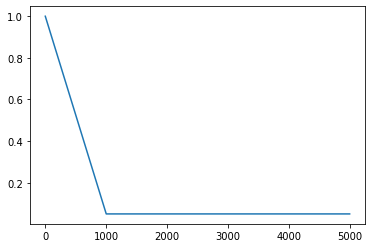

In [26]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])

Now write a function of *EpsilonGreedyPolicy* class. This function takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon. Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [256]:
%%execwritefile -a dqn_autograde.py

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        # So we first need to choose whether we are taking a random action or a policy action
        if random.choices([True, False], weights=[self.epsilon, 1-self.epsilon], k=1)[0]:
            # This means we need to make a random choice for the action to be performed
            # The size of the output layer of Q_net is hardcoded as 2, so we will do that here too
            return random.choice(range(2))
        else:
            # This means we need to use the policy network
            obs = torch.Tensor(obs) # Stays Tensor if it was already one, becomes tensor if not
            action = torch.argmax(self.Q(obs)).item()
            return action
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

Appending to dqn_autograde.py


In [85]:
s = env.reset()
epg = EpsilonGreedyPolicy(Q_net, 0.05)
a = epg.sample_action(s)
assert not torch.is_tensor(a)
print (a)

0


In [146]:
?env.step

### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [253]:
# all_actions=torch.Tensor([[1, 3, 4], [2, 3, 3]])
# actions = torch.Tensor([1, 2])
actions = np.array([1, 2])
# print(all_actions[range(all_actions.shape[0]), actions.tolist()].unsqueeze(dim=1))
# torch.tensor([True, False]).dtype == torch.bool
isinstance(torch.Tensor(actions), torch.Tensor)
actions = torch.Tensor(actions)
torch.Tensor(torch.Tensor(actions))

tensor([1., 2.])

In [245]:
%%execwritefile -a dqn_autograde.py


def compute_q_vals(Q, states, actions=None):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    all_actions = Q(states)
    if not actions is None:
        Q_values = all_actions[range(all_actions.shape[0]), actions.squeeze().tolist()].unsqueeze(dim=1)
    else: # If actions are not defined, we take the best action's Q-value
        Q_values, _ = all_actions.max(dim=1, keepdim=True)
        # Could be updated to include the argmax as well
    return Q_values
    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    
    # First, we need to find the max Q-value (over actions) from the next states
    future_Q_vals = compute_q_vals(Q, next_states)
    
    # if the next state is terminal, the Q-value should be zero:
    # turns out that 'dones' is not actually a boolean tensor, but an integer tensor. Waste of memory..
    # In codegrade, the dones are in fact boolean tensors. What a mess :')
    if dones.dtype == torch.bool: # Use boolean operators when actual boolean tensor
        done_tensor = ~dones
        future_Q_vals *= done_tensor
    else: # Must be a numerical tensor representing boolean values then
        done_tensor = 1 - dones  
        future_Q_vals *= done_tensor
    
    # With some complicated indexing tricks we could prevent the done states from passing through the Q-net
    # but this will likely not save a significant amount of processing time
    
    target = rewards + discount_factor * future_Q_vals
    
    return target

def train(Q, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

Appending to dqn_autograde.py


In [226]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(Q_net.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(Q_net, memory, optimizer, batch_size, discount_factor)

print (loss)

0.6255685091018677


### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [182]:
?env.env

In [261]:
%%execwritefile -a dqn_autograde.py

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  
    for i in range(num_episodes):
        state = env.reset()
        
        steps = 0
        while True:
            # So it seems like here we should sample an episode,
            # and every step update the weights
            
            # So first sample an action
            sampled_action = policy.sample_action(state)
            
            # Then step 
            state_tuple = env.step(sampled_action)
            
            # Store this transition in memory:
            s_next, r, done, _ = state_tuple
            memory.push((state, sampled_action, r, s_next, done))
            state = s_next
            
            # Now that we have added a transition, we should try to train based on our memory
            loss = train(Q, memory, optimizer, batch_size, discount_factor)
            # This is like online learning, we could also only train once per episode
            
            steps += 1
            global_steps += 1
            
            # Update epsilon
            policy.set_epsilon(get_epsilon(global_steps))
            
            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                    print("epsilon: ", policy.epsilon)
                episode_durations.append(steps)
                #plot_durations()
                break
    return episode_durations

Appending to dqn_autograde.py


In [260]:
# Let's run it!
num_episodes = 1000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(50000)
num_hidden = 128
seed = 48  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.05)
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

 Episode 0 finished after 13 steps with reward 13.0
epsilon:  0.98765
 Episode 10 finished after 25 steps with reward 25.0
epsilon:  0.79765
 Episode 20 finished after 15 steps with reward 15.0
epsilon:  0.64375
 Episode 30 finished after 12 steps with reward 12.0
epsilon:  0.53545
 Episode 40 finished after 48 steps with reward 48.0
epsilon:  0.26375000000000004
 Episode 50 finished after 116 steps with reward 116.0
epsilon:  0.05
 Episode 60 finished after 152 steps with reward 152.0
epsilon:  0.05
 Episode 70 finished after 169 steps with reward 169.0
epsilon:  0.05
 Episode 80 finished after 176 steps with reward 176.0
epsilon:  0.05
 Episode 90 finished after 220 steps with reward 220.0
epsilon:  0.05
 Episode 100 finished after 202 steps with reward 202.0
epsilon:  0.05
 Episode 110 finished after 185 steps with reward 185.0
epsilon:  0.05
 Episode 120 finished after 170 steps with reward 170.0
epsilon:  0.05
 Episode 130 finished after 206 steps with reward 206.0
epsilon:  0.05


In [259]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.05)
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

 Episode 0 finished after 19 steps with reward 19.0
epsilon:  0.98195
 Episode 10 finished after 19 steps with reward 19.0
epsilon:  0.78055
 Episode 20 finished after 12 steps with reward 12.0
epsilon:  0.63235
 Episode 30 finished after 24 steps with reward 24.0
epsilon:  0.4585
 Episode 40 finished after 48 steps with reward 48.0
epsilon:  0.08515000000000006
 Episode 50 finished after 82 steps with reward 82.0
epsilon:  0.05
 Episode 60 finished after 166 steps with reward 166.0
epsilon:  0.05
 Episode 70 finished after 75 steps with reward 75.0
epsilon:  0.05
 Episode 80 finished after 143 steps with reward 143.0
epsilon:  0.05
 Episode 90 finished after 173 steps with reward 173.0
epsilon:  0.05


Text(0.5, 1.0, 'Episode durations per episode')

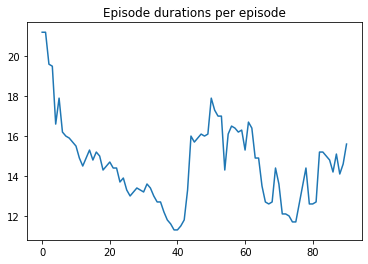

In [194]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**